# Week 3: Kernel Regression and Regularization

## Lecture 6 (Mon, Jan 25) Kernel Regression

Please see the notes in Canvas for details, but we derived the parameters of a local linear regression model in the neighborhood of the point $x_0$ for $d=1$ by minimizing the weighted squared error loss function,

$$L(\alpha(x_0),\beta(x_0))=\sum\limits_{i=1}^N K_\lambda(x_0,x_i)\left(y_i - \alpha(x_0) - \beta(x_0)x_i\right)^2$$

The function $K_\lambda$ is called a kernel, or weighting, function. Intuitively, it measures how similar two points are. If $x_i$ and $x_0$ are close, the kernel function will be large, so $x_i$ will have a larger impact on the local regression model. A common kernel function is the Gaussian kernel,

$$K_\lambda(x_0,x) = \frac{1}{\lambda}\exp\left(-\frac{\|x-x_0\|_2^2}{2\lambda^2}\right)$$

We found the parameters of the unknown function $f$ in the vicinity of $x_0$ to be

$$\begin{pmatrix} \alpha(x_0) \\ \beta(x_0)\end{pmatrix} = (X^TW(x_0)X)^{-1}X^TW(x_0)y,$$

where

$$X = \begin{pmatrix}1 & x_1\\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n\end{pmatrix}, \quad y = \begin{pmatrix}y_1 \\ y_2 \\ \vdots \\ y_n\end{pmatrix}, \quad W(x_0)=\begin{pmatrix}K_\lambda(x_0,x_1) & & & \\ & K_\lambda(x_0,x_2) & & \\ & & \ddots & \\ & & & K_\lambda(x_0,x_n)\end{pmatrix}$$

where $W(x_0)$ is a diagonal matrix, meaning all entries except the diagonal entries are 0.

And, so, the local linear approximation of the unknown function $f$ at $x_0$ is


$$\hat{f}(x_0) = \begin{pmatrix}1 & x_0\end{pmatrix}(X^TW(x_0)X)^{-1}X^TW(x_0)y$$

## Lecture 7 (Wed, Jan 27) Implementing Kernel Regression

Let's write a class that will carry out kernel regression to construct local linear regression models. The class will take the $X$ data, $y$ data, and kernel function as inputs. But, first, let's import some basic things like `NumPy`, `pandas`, `matplotlib`, and some quality metrics for regression models from `scikit-learn`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Now, the class.

In [2]:
def GaussianKernel(x0, x, lam):
    return (1/lam) * np.exp(-np.linalg.norm(x0 - x) / (2 * lam))

class KernelRegression:
    def __init__(self, kernel_function, lam, fit_intercept = True):
        self.kernel_function = kernel_function
        self.fit_intercept = fit_intercept
        self.lam = lam

    def predict(self, x0, X, y):
        # find the number of X points
        n = X.shape[0]
        
        # add a column of ones if needed
        if self.fit_intercept:
            X = np.hstack((np.ones([n,1]), X))

        # construct the kernel matrix
        kernel = np.zeros([n, n])
        
        # populate the kernel matrix
        for i in range(n):
            kernel[i][i] = self.kernel_function(x0, X[i,:], self.lam)
                
        return np.array([1, np.float(x0)]) @ np.linalg.inv((X.T @ kernel @ X)) @ X.T @ kernel @ y

Let's try it with the shampoo dataset from last week. First, read in the data

In [3]:
# read the shampoo sales dataset
data = pd.read_csv('data/shampoo.csv')

# save the targets
y = data['Sales'].to_numpy()

# make a column vector of 0s with n elements
X = np.zeros([y.shape[0], 1])

# convert the vector to (0, 1, 2, ..., n)
X[:,0] = [i for i in range(y.shape[0])]

# split the data into train and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

Next, let's run the kernel regression model at each x value in a reasonable range using the Gaussian kernel with $\lambda\in\{0.1n:n=1,...,100\}$ and plot each.

lambda: 0.025 		r^2: 0.906 		train MAE: 27.749 		test MAE: 62.18
lambda: 0.075 		r^2: 0.854 		train MAE: 37.305 		test MAE: 54.464
lambda: 0.125 		r^2: 0.845 		train MAE: 39.606 		test MAE: 53.2
lambda: 0.175 		r^2: 0.841 		train MAE: 40.842 		test MAE: 52.01
lambda: 0.226 		r^2: 0.838 		train MAE: 41.839 		test MAE: 51.032
lambda: 0.276 		r^2: 0.836 		train MAE: 42.641 		test MAE: 50.217
lambda: 0.326 		r^2: 0.835 		train MAE: 43.305 		test MAE: 49.496
lambda: 0.376 		r^2: 0.833 		train MAE: 43.885 		test MAE: 48.825
lambda: 0.426 		r^2: 0.832 		train MAE: 44.403 		test MAE: 48.178
lambda: 0.476 		r^2: 0.83 		train MAE: 44.873 		test MAE: 47.541
lambda: 0.526 		r^2: 0.828 		train MAE: 45.346 		test MAE: 46.907
lambda: 0.576 		r^2: 0.827 		train MAE: 45.823 		test MAE: 46.274
lambda: 0.627 		r^2: 0.825 		train MAE: 46.262 		test MAE: 45.641
lambda: 0.677 		r^2: 0.824 		train MAE: 46.768 		test MAE: 45.01
lambda: 0.727 		r^2: 0.822 		train MAE: 47.247 		test MAE: 44.382
lambda: 0.777 		

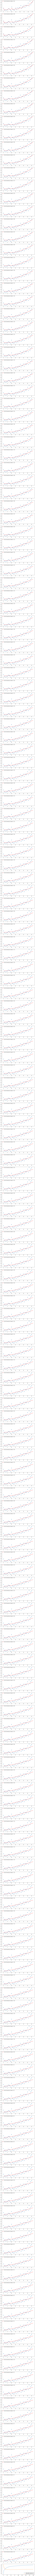

In [4]:
lamValues = np.linspace(0.025, 10, 200)

M = lamValues.shape[0]

# allow multiple plots
fig, axes = plt.subplots(nrows = M + 1, figsize = (10, 4*M))

trainMAE = []
testMAE = []

for (j, lam) in enumerate(lamValues):
    model = KernelRegression(GaussianKernel, lam)

    # compute the model coordinates
    xModel = [i for i in range(int(np.round(1.1 * np.max(X))))]
    yModel = [model.predict(i, trainX, trainY) for i in xModel]

    # plot the model
    label = 'Kernel Smoothing for lambda = ' + str(np.round(lam, 2))
    axes[j].scatter(X, y)
    axes[j].plot(xModel, yModel, 'r', label = label)
    axes[j].legend()
    
    # apply the functions to the test data and predict with the model
    trainPredictions = [model.predict(i, trainX, trainY) for i in trainX]
    testPredictions = [model.predict(i, trainX, trainY) for i in testX]
    
    # compute the training and test mean absolute error
    trainError = mean_absolute_error(trainY, trainPredictions)
    testError = mean_absolute_error(testY, testPredictions)
    
    # save the training and test mean absolute error
    trainMAE.append(trainError)
    testMAE.append(testError)

    # return quality metrics
    print('lambda:', np.round(lam, 3), '\t\tr^2:', np.round(r2_score(trainY, trainPredictions), 3),
          '\t\ttrain MAE:', np.round(trainError, 3), '\t\ttest MAE:', np.round(testError, 3))
    
# plot the errors
axes[M].plot(range(M), trainMAE, label = 'Training Mean Absolute Error')
axes[M].plot(range(M), testMAE, label = 'Testing Mean Absolute Error')
axes[M].legend()

As you can see, with a smaller $\lambda$ value, the fitted curve has some very sharp curves as the nearby points exert a pulling force on the locally linear curve. But, as we increase $\lambda$, the more smoothing we see in the predicted curve--as points further away from the input $x_0$ have more impact. Increasing $\lambda$ results in smoother and smoother curves (hence, the name kernel *smoothing*), which become nearer to a linear fit.

Beyond that, a larger $\lambda$ continually increases the training error and reduces the $r^2$, but the testing error, the more important measure, is reduced to at $\lambda=2.554$, but then starts to increase.